In [2]:
import sys
sys.path.append("/home/tsevero/notebooks/SAT_BIG_DATA/data-pipeline/batch/poc")
sys.path.append("/home/tsevero/notebooks/SAT_BIG_DATA/data-pipeline/batch/plugins")
sys.path.append("/home/tsevero/notebooks/SAT_BIG_DATA/data-pipeline/batch/dags")

#Import libs python
from pyspark.sql.types import *
from pyspark.sql.functions import *
from datetime import date

#Import libs internas
from utils import spark_utils_session as utils

from hooks.hdfs.hdfs_helper import HdfsHelper
from jobs.job_base_config import BaseETLJobClass

import poc_helper
poc_helper.load_env("PROD")

'.env_file' loaded!
ENV 'PROD' configured!


In [3]:
def get_session(profile: str, dynamic_allocation_enabled: bool = True) -> utils.DBASparkAppSession:
    """Generates DBASparkAppSession."""
    
    app_name = "tsevero_luciano_analises"
    
    spark_builder = (utils.DBASparkAppSession
                     .builder
                     .setAppName(app_name)
                     .usingProcessProfile(profile)
                    )
    
    if dynamic_allocation_enabled:
        spark_builder.autoResourceManagement()

    return spark_builder.build()

session = get_session(profile='efd_t2')

2025-11-26T18:25:13.627636Z [info     ] Using json file settings.      [root] loc=spark_utils_session.py:301
2025-11-26T18:25:13.629259Z [info     ] Exporting default ENV.         [root] loc=spark_utils_session.py:305
2025-11-26T18:25:13.629790Z [info     ] Exporting custom ENVs.         [root] loc=spark_utils_session.py:338
2025-11-26T18:25:13.630243Z [info     ] Building profile 'efd_t2'.     [root] loc=spark_utils_session.py:221
2025-11-26T18:25:13.630621Z [info     ] Not enough info for building the kerberos client. Ignoring it [root] loc=spark_utils_session.py:284


:: loading settings :: url = jar:file:/opt/cloudera/parcels/SPARK3-3.5.4.3.5.7191000.0-30-1.p0.68499982/lib/spark3/jars/ivy-2.5.2.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/tsevero/.ivy2/cache
The jars for the packages stored in: /home/tsevero/.ivy2/jars
com.databricks#spark-xml_2.12 added as a dependency
org.apache.iceberg#iceberg-spark-runtime-3.5_2.12 added as a dependency
com.oracle.database.security#oraclepki added as a dependency
com.oracle.database.security#osdt_core added as a dependency
com.oracle.database.security#osdt_cert added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-2280809f-6dd8-4a48-b9cf-fbea6efaad15;1.0
	confs: [default]
	found com.databricks#spark-xml_2.12;0.18.0 in central
	found commons-io#commons-io;2.11.0 in central
	found org.glassfish.jaxb#txw2;3.0.2 in central
	found org.apache.ws.xmlschema#xmlschema-core;2.3.0 in central
	found org.scala-lang.modules#scala-collection-compat_2.12;2.9.0 in central
	found org.apache.iceberg#iceberg-spark-runtime-3.5_2.12;1.9.2 in central
	found com.oracle.database.security#oraclepki;21.19.0.0 in central
	found com.oracle.databa

In [4]:
session.sparkSession.sql("SHOW DATABASES").show(truncate=False)

Hive Session ID = a51406fa-0b82-4b69-b65b-f57ab7e8711f


+------------------+
|namespace         |
+------------------+
|anac              |
|bcadastro         |
|bpe               |
|c115              |
|ccc               |
|ccg               |
|cte               |
|default           |
|destda            |
|detran_share      |
|dime              |
|due               |
|efd               |
|fci               |
|gecob             |
|gescol            |
|gessimples        |
|gplam             |
|information_schema|
|malhas            |
+------------------+
only showing top 20 rows



In [5]:
# ============================================================================
# CONFIGURAÇÃO INICIAL - 
# ============================================================================

import sys
import warnings
from datetime import datetime, date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# PySpark imports com aliases para evitar conflitos
from pyspark.sql.functions import (
    col as spark_col, 
    sum as spark_sum, 
    avg as spark_avg,
    count as spark_count,
    when as spark_when,
    desc as spark_desc,
    asc as spark_asc,
    round as spark_round,
    concat as spark_concat,
    lit as spark_lit,
    max as spark_max,
    min as spark_min,
    stddev as spark_stddev,
    countDistinct as spark_countDistinct
)
from pyspark.sql.types import DoubleType, IntegerType

# Configurações de visualização
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['font.size'] = 11

# ✅ CORREÇÃO: Não usar abs() que conflita com PySpark
# pd.set_option('display.float_format', lambda x: f'{x:,.2f}' if abs(x) > 0.01 else f'{x:.6f}')
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

# Acesso ao Spark
spark = session.sparkSession

print("=" * 80)
print("🔍 SISTEMA")
print("=" * 80)
print(f"Sessão Spark: {spark.sparkContext.appName}")
print(f"Versão Spark: {spark.version}")
print(f"Iniciado em: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 80)

🔍 SISTEMA
Sessão Spark: tsevero_luciano_analises
Versão Spark: 3.5.4.3.5.7191000.0-30
Iniciado em: 2025-11-26 15:25:32


In [6]:
# ===================================================================
# CÉLULA 1: SETUP E FUNÇÃO HELPER PARA ANÁLISES
# ===================================================================

import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configurações de display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

print("="*80)
print("📊 PROJETO LUCIANO - ANÁLISES COMPLETAS")
print("="*80)
print(f"Data/Hora de Execução: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80)

# Função para executar queries e converter resultados
def executar_analise(nome_analise, query_sql, exibir=True, salvar=False):
    """
    Executa uma query SQL e retorna/exibe resultados
    
    Args:
        nome_analise: Nome da análise
        query_sql: Query SQL a executar
        exibir: Se True, exibe o resultado
        salvar: Se True, salva em CSV
    
    Returns:
        DataFrame pandas com resultados
    """
    try:
        print(f"\n{'='*80}")
        print(f"🔍 {nome_analise}")
        print(f"{'='*80}")
        
        # Executar query
        df_resultado = spark.sql(query_sql).toPandas()
        
        if exibir and len(df_resultado) > 0:
            print(f"\n📊 Resultados ({len(df_resultado):,} registros):")
            print(df_resultado.to_string(index=False))
        elif len(df_resultado) == 0:
            print("⚠️  Nenhum registro encontrado")
        
        if salvar:
            nome_arquivo = f"{nome_analise.replace(' ', '_').lower()}.csv"
            df_resultado.to_csv(nome_arquivo, index=False)
            print(f"\n💾 Salvo em: {nome_arquivo}")
        
        return df_resultado
        
    except Exception as e:
        print(f"❌ Erro na análise '{nome_analise}': {str(e)}")
        return pd.DataFrame()

print("\n✅ Setup concluído!")

📊 PROJETO LUCIANO - ANÁLISES COMPLETAS
Data/Hora de Execução: 2025-11-26 15:25:50

✅ Setup concluído!


In [7]:
# ===================================================================
# CÉLULA 2: DASHBOARD EXECUTIVO E ESTATÍSTICAS GERAIS
# ===================================================================

print("\n" + "="*80)
print("📊 SEÇÃO 1: DASHBOARD EXECUTIVO")
print("="*80)

# ========================================
# ANÁLISE 1: DASHBOARD EXECUTIVO
# ========================================

query_dashboard = """
SELECT 
    'VOLUMETRIA GERAL' AS secao,
    'Total de Empresas Analisadas' AS metrica,
    CAST(total_empresas AS STRING) AS valor,
    'Empresas únicas no período de 60 meses' AS observacao
FROM teste.luciano_resumo

UNION ALL

SELECT 
    'VOLUMETRIA GERAL',
    'Total de Protocolos',
    CAST(total_protocolos AS STRING),
    'Cancelamentos processados'
FROM teste.luciano_resumo

UNION ALL

SELECT 
    'RISCO',
    'Empresas Risco CRÍTICO',
    CONCAT(CAST(empresas_risco_critico AS STRING), ' (', CAST(perc_risco_critico AS STRING), '%)'),
    'Prioridade máxima de fiscalização'
FROM teste.luciano_resumo

UNION ALL

SELECT 
    'RISCO',
    'Empresas Risco ALTO',
    CONCAT(CAST(empresas_risco_alto AS STRING), ' (', CAST(perc_risco_alto AS STRING), '%)'),
    'Segunda prioridade'
FROM teste.luciano_resumo

UNION ALL

SELECT 
    'EFETIVIDADE',
    'Taxa Média de Permanência',
    CONCAT(CAST(taxa_media_permanencia AS STRING), '%'),
    'Empresas que continuam canceladas'
FROM teste.luciano_resumo

UNION ALL

SELECT 
    'CRÉDITO',
    'Saldo Credor Total em Risco',
    CONCAT('R$ ', CAST(ROUND(saldo_credor_total, 2) AS STRING)),
    'Valor acumulado em empresas canceladas'
FROM teste.luciano_resumo

UNION ALL

SELECT 
    'INDÍCIOS',
    'Empresas com Indícios',
    CONCAT(CAST(empresas_com_indicios AS STRING), ' (', CAST(perc_com_indicios AS STRING), '%)'),
    'Empresas sinalizadas por irregularidades'
FROM teste.luciano_resumo
"""

df_dashboard = executar_analise("1. Dashboard Executivo", query_dashboard)

# ========================================
# ANÁLISE 2: ESTATÍSTICAS GERAIS
# ========================================

query_estatisticas = """
SELECT 
    COUNT(DISTINCT cnpj) AS total_empresas,
    SUM(total_protocolos) AS total_protocolos,
    ROUND(AVG(total_protocolos), 2) AS media_protocolos_por_empresa,
    MAX(total_protocolos) AS max_protocolos_empresa,
    
    SUM(CASE WHEN classificacao_risco_final = 'CRÍTICO' THEN 1 ELSE 0 END) AS qtde_critico,
    SUM(CASE WHEN classificacao_risco_final = 'ALTO' THEN 1 ELSE 0 END) AS qtde_alto,
    SUM(CASE WHEN classificacao_risco_final = 'MÉDIO' THEN 1 ELSE 0 END) AS qtde_medio,
    SUM(CASE WHEN classificacao_risco_final = 'BAIXO' THEN 1 ELSE 0 END) AS qtde_baixo,
    
    ROUND(AVG(score_total), 2) AS score_medio,
    ROUND(STDDEV(score_total), 2) AS desvio_padrao_score,
    ROUND(MIN(score_total), 2) AS score_minimo,
    ROUND(MAX(score_total), 2) AS score_maximo,
    
    SUM(flag_atualmente_cancelada) AS ainda_canceladas,
    COUNT(*) - SUM(flag_atualmente_cancelada) AS reativadas,
    ROUND(SUM(flag_atualmente_cancelada) * 100.0 / COUNT(*), 2) AS perc_canceladas,
    
    SUM(flag_empresa_reincidente) AS empresas_reincidentes,
    ROUND(SUM(flag_empresa_reincidente) * 100.0 / COUNT(*), 2) AS perc_reincidentes,
    
    SUM(saldo_credor_atual) AS saldo_total,
    ROUND(AVG(saldo_credor_atual), 2) AS saldo_medio,
    SUM(CASE WHEN saldo_credor_atual > 1000000 THEN 1 ELSE 0 END) AS empresas_saldo_acima_1M,
    SUM(CASE WHEN saldo_credor_atual > 10000000 THEN 1 ELSE 0 END) AS empresas_saldo_acima_10M,
    
    SUM(flag_tem_indicios) AS com_indicios,
    SUM(flag_tem_indicios_graves) AS com_indicios_graves,
    SUM(qtde_indicios) AS total_indicios,
    ROUND(AVG(CASE WHEN flag_tem_indicios = 1 THEN qtde_indicios END), 2) AS media_indicios_quando_tem

FROM teste.luciano_scores
"""

df_estatisticas = executar_analise("2. Estatísticas Gerais", query_estatisticas)

print("\n✅ Seção 1 concluída!")


📊 SEÇÃO 1: DASHBOARD EXECUTIVO

🔍 1. Dashboard Executivo



📊 Resultados (7 registros):
           secao                      metrica           valor                               observacao
VOLUMETRIA GERAL Total de Empresas Analisadas          243053   Empresas únicas no período de 60 meses
VOLUMETRIA GERAL          Total de Protocolos          277218                Cancelamentos processados
           RISCO       Empresas Risco CRÍTICO       0 (0.00%)        Prioridade máxima de fiscalização
           RISCO          Empresas Risco ALTO       0 (0.00%)                       Segunda prioridade
     EFETIVIDADE    Taxa Média de Permanência          95.63%        Empresas que continuam canceladas
         CRÉDITO  Saldo Credor Total em Risco R$ 383525764.13   Valor acumulado em empresas canceladas
        INDÍCIOS        Empresas com Indícios   22871 (9.41%) Empresas sinalizadas por irregularidades

🔍 2. Estatísticas Gerais


[Stage 1:============================================>              (3 + 1) / 4]


📊 Resultados (1 registros):
 total_empresas  total_protocolos  media_protocolos_por_empresa  max_protocolos_empresa  qtde_critico  qtde_alto  qtde_medio  qtde_baixo score_medio  desvio_padrao_score score_minimo score_maximo  ainda_canceladas  reativadas perc_canceladas  empresas_reincidentes perc_reincidentes  saldo_total saldo_medio  empresas_saldo_acima_1M  empresas_saldo_acima_10M  com_indicios  com_indicios_graves  total_indicios  media_indicios_quando_tem
         243053            277218                          1.14                      10             0          0        2583      240470        9.08                 5.63         1.25        48.50            232431       10622           95.63                   4819              1.98 383525764.13     1577.95                       68                         4         22871                    0          102889                       4.50

✅ Seção 1 concluída!


In [8]:
# ===================================================================
# CÉLULA 3: ANÁLISES DE RISCO E TEMPORAL
# ===================================================================

print("\n" + "="*80)
print("📊 SEÇÃO 2: ANÁLISES DE RISCO E TEMPORAL")
print("="*80)

# ========================================
# ANÁLISE 3: POR CLASSIFICAÇÃO DE RISCO
# ========================================

query_risco = """
SELECT 
    classificacao_risco_final,
    COUNT(*) AS qtde_empresas,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) AS perc_total,
    
    ROUND(AVG(score_total), 2) AS score_total_medio,
    ROUND(AVG(score_comportamento), 2) AS score_comportamento_medio,
    ROUND(AVG(score_credito), 2) AS score_credito_medio,
    ROUND(AVG(score_indicios), 2) AS score_indicios_medio,
    
    SUM(total_protocolos) AS total_protocolos,
    ROUND(AVG(total_protocolos), 2) AS media_protocolos,
    
    SUM(flag_atualmente_cancelada) AS ainda_canceladas,
    ROUND(AVG(taxa_permanencia_cancelamento_perc), 2) AS taxa_permanencia_media,
    
    SUM(saldo_credor_atual) AS saldo_total,
    ROUND(AVG(saldo_credor_atual), 2) AS saldo_medio,
    MAX(saldo_credor_atual) AS saldo_maximo,
    
    SUM(qtde_indicios) AS total_indicios,
    ROUND(AVG(qtde_indicios), 2) AS media_indicios,
    SUM(qtde_indicios_graves) AS indicios_graves,
    
    SUM(flag_saldo_alto_cancelada) AS flag_saldo_alto,
    SUM(flag_suspeita_valores_repetidos) AS flag_valores_repetidos

FROM teste.luciano_scores
GROUP BY classificacao_risco_final
ORDER BY 
    CASE classificacao_risco_final
        WHEN 'CRÍTICO' THEN 1
        WHEN 'ALTO' THEN 2
        WHEN 'MÉDIO' THEN 3
        WHEN 'BAIXO' THEN 4
    END
"""

df_risco = executar_analise("3. Análise por Classificação de Risco", query_risco, salvar=True)

# ========================================
# ANÁLISE 4: EVOLUÇÃO TEMPORAL MENSAL
# ========================================

query_temporal_mensal = """
SELECT 
    periodo_cancelamento,
    ano_cancelamento,
    mes_cancelamento,
    
    qtde_protocolos,
    qtde_empresas_distintas,
    qtde_usuarios_distintos,
    
    qtde_automaticos,
    qtde_manuais,
    ROUND(qtde_automaticos * 100.0 / qtde_protocolos, 2) AS perc_automaticos,
    
    qtde_ainda_canceladas,
    qtde_reativadas,
    taxa_permanencia_perc,
    taxa_reativacao_perc,
    
    ROUND(media_dias_ate_reativacao, 0) AS dias_medios_reativacao

FROM teste.luciano_temporal
ORDER BY ano_cancelamento DESC, mes_cancelamento DESC
LIMIT 24
"""

df_temporal_mensal = executar_analise("4. Evolução Temporal Mensal (Últimos 24 meses)", 
                                       query_temporal_mensal, salvar=True)

# ========================================
# ANÁLISE 5: EVOLUÇÃO TEMPORAL ANUAL
# ========================================

query_temporal_anual = """
SELECT 
    ano_cancelamento,
    
    SUM(qtde_protocolos) AS total_protocolos,
    SUM(qtde_empresas_distintas) AS empresas_distintas,
    
    SUM(qtde_automaticos) AS total_automaticos,
    SUM(qtde_manuais) AS total_manuais,
    ROUND(SUM(qtde_automaticos) * 100.0 / SUM(qtde_protocolos), 2) AS perc_automaticos,
    
    SUM(qtde_ainda_canceladas) AS total_ainda_canceladas,
    SUM(qtde_reativadas) AS total_reativadas,
    ROUND(SUM(qtde_ainda_canceladas) * 100.0 / SUM(qtde_protocolos), 2) AS taxa_permanencia_anual,
    
    COUNT(DISTINCT periodo_cancelamento) AS meses_com_atividade,
    ROUND(AVG(qtde_protocolos), 2) AS media_mensal_protocolos,
    MAX(qtde_protocolos) AS pico_mensal

FROM teste.luciano_temporal
GROUP BY ano_cancelamento
ORDER BY ano_cancelamento DESC
"""

df_temporal_anual = executar_analise("5. Evolução Temporal Anual", query_temporal_anual, salvar=True)

print("\n✅ Seção 2 concluída!")


📊 SEÇÃO 2: ANÁLISES DE RISCO E TEMPORAL

🔍 3. Análise por Classificação de Risco

📊 Resultados (2 registros):
classificacao_risco_final  qtde_empresas perc_total score_total_medio  score_comportamento_medio  score_credito_medio  score_indicios_medio  total_protocolos  media_protocolos  ainda_canceladas taxa_permanencia_media  saldo_total saldo_medio saldo_maximo  total_indicios  media_indicios  indicios_graves  flag_saldo_alto  flag_valores_repetidos
                    MÉDIO           2583       1.06             34.92                      39.19                25.48                 40.51              6517              2.52               241                   9.33 191372878.11    74089.38  34526545.86           25341            9.81                0               83                    1867
                    BAIXO         240470      98.94              8.81                      27.67                 3.02                  2.08            270701              1.13            232190      

In [9]:
# ===================================================================
# CÉLULA 4: ANÁLISES GEOGRÁFICAS E POR CNAE
# ===================================================================

print("\n" + "="*80)
print("📊 SEÇÃO 3: ANÁLISES GEOGRÁFICAS E POR SETOR")
print("="*80)

# ========================================
# ANÁLISE 6: POR MUNICÍPIO (TOP 20)
# ========================================

query_municipio = """
SELECT 
    m.municipio,
    m.uf,
    m.gerencia_regional,
    
    COUNT(DISTINCT m.cnpj) AS qtde_empresas,
    SUM(m.total_protocolos) AS total_protocolos,
    ROUND(AVG(m.total_protocolos), 2) AS media_protocolos,
    
    SUM(CASE WHEN s.classificacao_risco_final IN ('CRÍTICO', 'ALTO') THEN 1 ELSE 0 END) AS empresas_alto_risco,
    ROUND(SUM(CASE WHEN s.classificacao_risco_final IN ('CRÍTICO', 'ALTO') THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS perc_alto_risco,
    
    SUM(m.qtde_ainda_cancelada) AS ainda_canceladas,
    ROUND(AVG(m.taxa_permanencia_cancelamento_perc), 2) AS taxa_permanencia_media,
    
    SUM(CASE WHEN m.flag_empresa_reincidente = 1 THEN 1 ELSE 0 END) AS reincidentes,
    
    COUNT(DISTINCT m.cd_cnae) AS diversidade_cnaes

FROM teste.luciano_metricas m
LEFT JOIN teste.luciano_scores s ON m.cnpj = s.cnpj
WHERE m.municipio IS NOT NULL
GROUP BY m.municipio, m.uf, m.gerencia_regional
HAVING COUNT(DISTINCT m.cnpj) >= 5
ORDER BY qtde_empresas DESC
LIMIT 20
"""

df_municipio = executar_analise("6. Análise por Município (Top 20)", query_municipio, salvar=True)

# ========================================
# ANÁLISE 7: POR GERÊNCIA REGIONAL
# ========================================

query_gerfe = """
SELECT 
    m.gerencia_regional,
    
    COUNT(DISTINCT m.cnpj) AS qtde_empresas,
    SUM(m.total_protocolos) AS total_protocolos,
    ROUND(AVG(m.total_protocolos), 2) AS media_protocolos,
    
    COUNT(DISTINCT m.municipio) AS qtde_municipios,
    COUNT(DISTINCT m.cd_cnae) AS qtde_cnaes,
    
    SUM(CASE WHEN s.classificacao_risco_final = 'CRÍTICO' THEN 1 ELSE 0 END) AS risco_critico,
    SUM(CASE WHEN s.classificacao_risco_final = 'ALTO' THEN 1 ELSE 0 END) AS risco_alto,
    ROUND(SUM(CASE WHEN s.classificacao_risco_final IN ('CRÍTICO', 'ALTO') THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS perc_alto_risco,
    
    ROUND(AVG(s.score_total), 2) AS score_medio,
    
    SUM(m.qtde_ainda_cancelada) AS ainda_canceladas,
    ROUND(AVG(m.taxa_permanencia_cancelamento_perc), 2) AS taxa_permanencia,
    
    SUM(c.saldo_credor_atual) AS saldo_credor_total,
    ROUND(AVG(c.saldo_credor_atual), 2) AS saldo_credor_medio,
    
    SUM(i.qtde_indicios) AS total_indicios,
    ROUND(AVG(i.qtde_indicios), 2) AS media_indicios

FROM teste.luciano_metricas m
LEFT JOIN teste.luciano_scores s ON m.cnpj = s.cnpj
LEFT JOIN teste.luciano_credito c ON m.cnpj = c.cnpj
LEFT JOIN teste.luciano_indicios i ON m.cnpj = i.cnpj
WHERE m.gerencia_regional IS NOT NULL
GROUP BY m.gerencia_regional
ORDER BY qtde_empresas DESC
"""

df_gerfe = executar_analise("7. Análise por Gerência Regional", query_gerfe, salvar=True)

# ========================================
# ANÁLISE 8: POR CNAE (TOP 15)
# ========================================

query_cnae = """
SELECT 
    m.cd_cnae,
    MAX(m.descricao_cnae) AS descricao_cnae,
    
    COUNT(DISTINCT m.cnpj) AS qtde_empresas,
    SUM(m.total_protocolos) AS total_protocolos,
    ROUND(AVG(m.total_protocolos), 2) AS media_protocolos,
    
    SUM(CASE WHEN s.classificacao_risco_final IN ('CRÍTICO', 'ALTO') THEN 1 ELSE 0 END) AS alto_risco,
    ROUND(SUM(CASE WHEN s.classificacao_risco_final IN ('CRÍTICO', 'ALTO') THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS perc_alto_risco,
    
    ROUND(AVG(s.score_total), 2) AS score_medio,
    ROUND(AVG(s.score_comportamento), 2) AS score_comportamento,
    ROUND(AVG(s.score_credito), 2) AS score_credito,
    ROUND(AVG(s.score_indicios), 2) AS score_indicios,
    
    SUM(c.saldo_credor_atual) AS saldo_total,
    ROUND(AVG(c.saldo_credor_atual), 2) AS saldo_medio,
    
    SUM(i.qtde_indicios) AS total_indicios,
    SUM(i.qtde_indicios_graves) AS indicios_graves,
    
    SUM(m.flag_empresa_reincidente) AS reincidentes,
    ROUND(SUM(m.flag_empresa_reincidente) * 100.0 / COUNT(*), 2) AS perc_reincidentes

FROM teste.luciano_metricas m
LEFT JOIN teste.luciano_scores s ON m.cnpj = s.cnpj
LEFT JOIN teste.luciano_credito c ON m.cnpj = c.cnpj
LEFT JOIN teste.luciano_indicios i ON m.cnpj = i.cnpj
WHERE m.cd_cnae IS NOT NULL
GROUP BY m.cd_cnae
HAVING COUNT(DISTINCT m.cnpj) >= 10
ORDER BY qtde_empresas DESC
LIMIT 15
"""

df_cnae = executar_analise("8. Análise por CNAE (Top 15)", query_cnae, salvar=True)

print("\n✅ Seção 3 concluída!")


📊 SEÇÃO 3: ANÁLISES GEOGRÁFICAS E POR SETOR

🔍 6. Análise por Município (Top 20)



📊 Resultados (20 registros):
         municipio uf                  gerencia_regional  qtde_empresas  total_protocolos  media_protocolos  empresas_alto_risco perc_alto_risco  ainda_canceladas taxa_permanencia_media  reincidentes  diversidade_cnaes
     FLORIANÓPOLIS SC GERÊNCIA REGIONAL DE FLORIANOPOLIS          19227             22041              1.15                    0            0.00             18473                  96.08           436                659
         JOINVILLE SC     GERÊNCIA REGIONAL DE JOINVILLE          16928             19326              1.14                    0            0.00             16086                  95.03           333                678
            ITAJAÍ SC        GERÊNCIA REGIONAL DE ITAJAI          12135             14284              1.18                    0            0.00             11409                  94.02           353                665
          BLUMENAU SC      GERÊNCIA REGIONAL DE BLUMENAU          12130             13567     


📊 Resultados (16 registros):
                       gerencia_regional  qtde_empresas  total_protocolos  media_protocolos  qtde_municipios  qtde_cnaes  risco_critico  risco_alto perc_alto_risco score_medio  ainda_canceladas taxa_permanencia saldo_credor_total saldo_credor_medio  total_indicios  media_indicios
             GERÊNCIA REGIONAL DE ITAJAI          43139             49388              1.14               19         858              0           0            0.00        9.49             41123            95.33       109386057.91            2535.67           21969            0.51
      GERÊNCIA REGIONAL DE FLORIANOPOLIS          40123             46300              1.15               14         822              0           0            0.00        9.02             38293            95.44        35197974.30             877.25           16466            0.41
          GERÊNCIA REGIONAL DE JOINVILLE          32875             37282              1.13               13         839       

[Stage 86:===================================================>      (8 + 1) / 9]


📊 Resultados (15 registros):
cd_cnae                                                                                                                 descricao_cnae  qtde_empresas  total_protocolos  media_protocolos  alto_risco perc_alto_risco score_medio  score_comportamento  score_credito  score_indicios saldo_total saldo_medio  total_indicios  indicios_graves  reincidentes perc_reincidentes
4781400                                                                        Comércio varejista de artigos do vestuário e acessórios          20882             22845              1.09           0            0.00        8.04                27.27           2.15            1.17  3005994.55      143.95            3539                0           188              0.90
5611203                                                                                Lanchonetes, casas de chá, de sucos e similares          10091             11139              1.10           0            0.00        8.16           

In [10]:
# ===================================================================
# CÉLULA 5: ANÁLISES DE CRÉDITO E INDÍCIOS
# ===================================================================

print("\n" + "="*80)
print("📊 SEÇÃO 4: ANÁLISES DE CRÉDITO E INDÍCIOS")
print("="*80)

# ========================================
# ANÁLISE 9: ANÁLISE DE CRÉDITO DETALHADA
# ========================================

query_credito = """
SELECT 
    CASE 
        WHEN saldo_credor_atual <= 0 THEN '0 - Sem saldo'
        WHEN saldo_credor_atual <= 10000 THEN '1 - Até 10k'
        WHEN saldo_credor_atual <= 100000 THEN '2 - 10k a 100k'
        WHEN saldo_credor_atual <= 500000 THEN '3 - 100k a 500k'
        WHEN saldo_credor_atual <= 1000000 THEN '4 - 500k a 1M'
        WHEN saldo_credor_atual <= 10000000 THEN '5 - 1M a 10M'
        ELSE '6 - Acima de 10M'
    END AS faixa_saldo,
    
    COUNT(*) AS qtde_empresas,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) AS perc_total,
    
    SUM(saldo_credor_atual) AS saldo_total_faixa,
    ROUND(AVG(saldo_credor_atual), 2) AS saldo_medio,
    
    SUM(vl_credito_60m) AS credito_60m_total,
    SUM(vl_credito_presumido_60m) AS credito_presumido_total,
    
    SUM(flag_saldo_alto_cancelada) AS flag_saldo_alto,
    SUM(flag_suspeita_valores_repetidos) AS flag_valores_repetidos,
    SUM(flag_saldo_sem_declaracao) AS flag_sem_declaracao,
    SUM(flag_credito_muito_estavel) AS flag_muito_estavel,
    SUM(flag_crescimento_anormal_saldo) AS flag_crescimento_anormal,
    
    SUM(flag_saldo_alto_cancelada + flag_suspeita_valores_repetidos + 
        flag_saldo_sem_declaracao + flag_credito_muito_estavel + 
        flag_crescimento_anormal_saldo) AS total_alertas

FROM teste.luciano_credito
GROUP BY 
    CASE 
        WHEN saldo_credor_atual <= 0 THEN '0 - Sem saldo'
        WHEN saldo_credor_atual <= 10000 THEN '1 - Até 10k'
        WHEN saldo_credor_atual <= 100000 THEN '2 - 10k a 100k'
        WHEN saldo_credor_atual <= 500000 THEN '3 - 100k a 500k'
        WHEN saldo_credor_atual <= 1000000 THEN '4 - 500k a 1M'
        WHEN saldo_credor_atual <= 10000000 THEN '5 - 1M a 10M'
        ELSE '6 - Acima de 10M'
    END
ORDER BY faixa_saldo
"""

df_credito = executar_analise("9. Análise de Crédito por Faixa de Saldo", query_credito, salvar=True)

# ========================================
# ANÁLISE 10: TOP 20 EMPRESAS - MAIOR SALDO CREDOR
# ========================================

query_top_saldo = """
SELECT 
    c.cnpj,
    c.nome_contribuinte,
    s.classificacao_risco_final,
    s.score_total,
    
    c.saldo_credor_atual,
    c.vl_credito_60m,
    c.vl_credito_presumido_60m,
    
    c.perc_valores_iguais_12m,
    c.variacao_saldo_perc_60m,
    
    m.total_protocolos,
    m.taxa_permanencia_cancelamento_perc,
    
    i.qtde_indicios,
    
    c.flag_saldo_alto_cancelada,
    c.flag_suspeita_valores_repetidos,
    c.flag_saldo_sem_declaracao,
    c.flag_crescimento_anormal_saldo

FROM teste.luciano_credito c
JOIN teste.luciano_scores s ON c.cnpj = s.cnpj
JOIN teste.luciano_metricas m ON c.cnpj = m.cnpj
LEFT JOIN teste.luciano_indicios i ON c.cnpj = i.cnpj
WHERE s.flag_atualmente_cancelada = 1
    AND c.saldo_credor_atual > 0
ORDER BY c.saldo_credor_atual DESC
LIMIT 20
"""

df_top_saldo = executar_analise("10. Top 20 Empresas - Maior Saldo Credor em Risco", 
                                 query_top_saldo, salvar=True)

# ========================================
# ANÁLISE 11: ANÁLISE DE INDÍCIOS DETALHADA
# ========================================

query_indicios = """
SELECT 
    classificacao_risco_indicios,
    
    COUNT(*) AS qtde_empresas,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) AS perc_total,
    
    SUM(qtde_indicios) AS total_indicios,
    ROUND(AVG(qtde_indicios), 2) AS media_indicios,
    MAX(qtde_indicios) AS max_indicios,
    
    SUM(qtde_indicios_graves) AS total_graves,
    ROUND(AVG(qtde_indicios_graves), 2) AS media_graves,
    
    SUM(soma_scores_indicios) AS soma_total_scores,
    ROUND(AVG(soma_scores_indicios), 2) AS media_scores,
    
    SUM(qtde_indicios_docs_fiscais) AS indicios_docs_fiscais,
    SUM(qtde_indicios_relacionamentos) AS indicios_relacionamentos,
    SUM(qtde_indicios_declaracoes) AS indicios_declaracoes,
    SUM(qtde_indicios_cadastro) AS indicios_cadastro,
    
    SUM(flag_tem_indicios) AS com_indicios,
    SUM(flag_tem_indicios_graves) AS com_indicios_graves

FROM teste.luciano_indicios
GROUP BY classificacao_risco_indicios
ORDER BY 
    CASE classificacao_risco_indicios
        WHEN 'CRÍTICO' THEN 1
        WHEN 'ALTO' THEN 2
        WHEN 'MÉDIO' THEN 3
        WHEN 'BAIXO' THEN 4
        WHEN 'SEM_INDICIOS' THEN 5
    END
"""

df_indicios = executar_analise("11. Análise de Indícios Detalhada", query_indicios, salvar=True)

# ========================================
# ANÁLISE 12: TOP 20 EMPRESAS - MAIS INDÍCIOS
# ========================================

query_top_indicios = """
SELECT 
    i.cnpj,
    i.nome_contribuinte,
    i.classificacao_risco_indicios,
    
    i.qtde_indicios,
    i.qtde_tipos_indicios_distintos,
    i.soma_scores_indicios,
    i.qtde_indicios_graves,
    
    i.qtde_indicios_docs_fiscais,
    i.qtde_indicios_relacionamentos,
    i.qtde_indicios_declaracoes,
    i.qtde_indicios_cadastro,
    
    s.classificacao_risco_final,
    s.score_total,
    s.flag_atualmente_cancelada,
    
    c.saldo_credor_atual,
    
    m.total_protocolos,
    m.taxa_permanencia_cancelamento_perc

FROM teste.luciano_indicios i
JOIN teste.luciano_scores s ON i.cnpj = s.cnpj
JOIN teste.luciano_metricas m ON i.cnpj = m.cnpj
LEFT JOIN teste.luciano_credito c ON i.cnpj = c.cnpj
WHERE i.qtde_indicios > 0
ORDER BY i.soma_scores_indicios DESC, i.qtde_indicios DESC
LIMIT 20
"""

df_top_indicios = executar_analise("12. Top 20 Empresas - Mais Indícios", 
                                    query_top_indicios, salvar=True)

print("\n✅ Seção 4 concluída!")


📊 SEÇÃO 4: ANÁLISES DE CRÉDITO E INDÍCIOS

🔍 9. Análise de Crédito por Faixa de Saldo

📊 Resultados (7 registros):
     faixa_saldo  qtde_empresas perc_total saldo_total_faixa saldo_medio credito_60m_total credito_presumido_total  flag_saldo_alto  flag_valores_repetidos  flag_sem_declaracao  flag_muito_estavel  flag_crescimento_anormal  total_alertas
   0 - Sem saldo         238759      98.23              0.00        0.00     9437490923.45           1873220682.30                0                   16463                    0                 595                      3450          20508
     1 - Até 10k           2673       1.10        5891801.84     2204.19      303759180.38           1237969124.87                0                    1444                    0                   1                      1147           2592
  2 - 10k a 100k           1155       0.48       40062802.09    34686.41      937628730.55            252167500.17                0                     480               

In [11]:
# ===================================================================
# CÉLULA 6: ANÁLISES DE DESEMPENHO DOS FISCAIS
# ===================================================================

print("\n" + "="*80)
print("📊 SEÇÃO 5: ANÁLISES DE DESEMPENHO DOS FISCAIS")
print("="*80)

# ========================================
# ANÁLISE 13: DESEMPENHO GERAL DOS FISCAIS
# ========================================

query_fiscais = """
SELECT 
    matricula_fiscal,
    nome_fiscal,
    
    qtde_protocolos_fiscal,
    qtde_empresas_distintas,
    anos_atuacao,
    
    qtde_cancelamentos_efetivos,
    taxa_efetividade_perc,
    taxa_reativacao_perc,
    
    ROUND(media_dias_processamento, 1) AS dias_processamento_medio,
    
    ROUND(media_protocolos_por_empresa, 2) AS media_protocolos_empresa,
    qtde_casos_reincidentes,
    
    qtde_individuais,
    qtde_massivos,
    
    total_chats,
    total_observacoes,
    perc_dedicacao_malhas,
    
    data_primeiro_protocolo,
    data_ultimo_protocolo,
    DATEDIFF(data_ultimo_protocolo, data_primeiro_protocolo) AS dias_atuacao

FROM teste.luciano_fiscal
ORDER BY qtde_protocolos_fiscal DESC
"""

df_fiscais = executar_analise("13. Análise de Desempenho dos Fiscais", query_fiscais, salvar=True)

# ========================================
# ANÁLISE 14: RANKING FISCAIS - EFETIVIDADE
# ========================================

query_ranking_fiscais = """
SELECT 
    ROW_NUMBER() OVER (ORDER BY taxa_efetividade_perc DESC, qtde_protocolos_fiscal DESC) AS ranking,
    matricula_fiscal,
    nome_fiscal,
    qtde_protocolos_fiscal,
    qtde_cancelamentos_efetivos,
    taxa_efetividade_perc,
    taxa_reativacao_perc,
    ROUND(media_dias_processamento, 1) AS dias_processamento,
    qtde_casos_reincidentes

FROM teste.luciano_fiscal
WHERE qtde_protocolos_fiscal >= 10
ORDER BY taxa_efetividade_perc DESC, qtde_protocolos_fiscal DESC
LIMIT 15
"""

df_ranking_fiscais = executar_analise("14. Ranking Fiscais - Maior Efetividade (Top 15)", 
                                       query_ranking_fiscais, salvar=True)

print("\n✅ Seção 5 concluída!")


📊 SEÇÃO 5: ANÁLISES DE DESEMPENHO DOS FISCAIS

🔍 13. Análise de Desempenho dos Fiscais

📊 Resultados (102 registros):
matricula_fiscal                               nome_fiscal  qtde_protocolos_fiscal  qtde_empresas_distintas  anos_atuacao  qtde_cancelamentos_efetivos taxa_efetividade_perc taxa_reativacao_perc  dias_processamento_medio  media_protocolos_empresa  qtde_casos_reincidentes  qtde_individuais  qtde_massivos  total_chats  total_observacoes perc_dedicacao_malhas data_primeiro_protocolo data_ultimo_protocolo  dias_atuacao
 3441687                          LUCIANO TREVISAN FREITAS                    9258                     9061             5                         7648                 82.61                17.39                      3.20                      1.54                      809              9258              0            0                  0                  0.00     2021-01-20 11:24:00   2025-11-24 15:31:27          1769
 3012034                              CARLOS 

In [12]:
# ===================================================================
# CÉLULA 7: ANÁLISES CRUZADAS E REINCIDÊNCIA
# ===================================================================

print("\n" + "="*80)
print("📊 SEÇÃO 6: ANÁLISES CRUZADAS E REINCIDÊNCIA")
print("="*80)

# ========================================
# ANÁLISE 15: MATRIZ RISCO x CRÉDITO
# ========================================

query_matriz_risco_credito = """
SELECT 
    s.classificacao_risco_final,
    
    SUM(CASE WHEN c.saldo_credor_atual <= 0 THEN 1 ELSE 0 END) AS sem_saldo,
    SUM(CASE WHEN c.saldo_credor_atual > 0 AND c.saldo_credor_atual <= 100000 THEN 1 ELSE 0 END) AS ate_100k,
    SUM(CASE WHEN c.saldo_credor_atual > 100000 AND c.saldo_credor_atual <= 1000000 THEN 1 ELSE 0 END) AS de_100k_a_1M,
    SUM(CASE WHEN c.saldo_credor_atual > 1000000 THEN 1 ELSE 0 END) AS acima_1M,
    
    COUNT(*) AS total,
    SUM(c.saldo_credor_atual) AS saldo_total,
    ROUND(AVG(c.saldo_credor_atual), 2) AS saldo_medio

FROM teste.luciano_scores s
LEFT JOIN teste.luciano_credito c ON s.cnpj = c.cnpj
GROUP BY s.classificacao_risco_final
ORDER BY 
    CASE s.classificacao_risco_final
        WHEN 'CRÍTICO' THEN 1
        WHEN 'ALTO' THEN 2
        WHEN 'MÉDIO' THEN 3
        WHEN 'BAIXO' THEN 4
    END
"""

df_matriz_risco_credito = executar_analise("15. Matriz Risco x Crédito", 
                                            query_matriz_risco_credito, salvar=True)

# ========================================
# ANÁLISE 16: ANÁLISE DE REINCIDÊNCIA
# ========================================

query_reincidencia = """
SELECT 
    CASE 
        WHEN m.total_protocolos = 1 THEN '1 - Único protocolo'
        WHEN m.total_protocolos = 2 THEN '2 - Dois protocolos'
        WHEN m.total_protocolos BETWEEN 3 AND 5 THEN '3 - De 3 a 5 protocolos'
        WHEN m.total_protocolos BETWEEN 6 AND 10 THEN '4 - De 6 a 10 protocolos'
        ELSE '5 - Mais de 10 protocolos'
    END AS faixa_protocolos,
    
    COUNT(*) AS qtde_empresas,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) AS perc_total,
    
    SUM(m.total_protocolos) AS total_protocolos_grupo,
    
    ROUND(AVG(m.taxa_permanencia_cancelamento_perc), 2) AS taxa_permanencia_media,
    ROUND(AVG(m.taxa_reativacao_perc), 2) AS taxa_reativacao_media,
    
    SUM(CASE WHEN s.classificacao_risco_final IN ('CRÍTICO', 'ALTO') THEN 1 ELSE 0 END) AS alto_risco,
    ROUND(SUM(CASE WHEN s.classificacao_risco_final IN ('CRÍTICO', 'ALTO') THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS perc_alto_risco,
    
    SUM(s.flag_atualmente_cancelada) AS ainda_canceladas,
    
    SUM(s.saldo_credor_atual) AS saldo_total,
    ROUND(AVG(s.saldo_credor_atual), 2) AS saldo_medio

FROM teste.luciano_scores s
JOIN teste.luciano_metricas m ON s.cnpj = m.cnpj
GROUP BY 
    CASE 
        WHEN m.total_protocolos = 1 THEN '1 - Único protocolo'
        WHEN m.total_protocolos = 2 THEN '2 - Dois protocolos'
        WHEN m.total_protocolos BETWEEN 3 AND 5 THEN '3 - De 3 a 5 protocolos'
        WHEN m.total_protocolos BETWEEN 6 AND 10 THEN '4 - De 6 a 10 protocolos'
        ELSE '5 - Mais de 10 protocolos'
    END
ORDER BY faixa_protocolos
"""

df_reincidencia = executar_analise("16. Análise de Reincidência", query_reincidencia, salvar=True)

print("\n✅ Seção 6 concluída!")


📊 SEÇÃO 6: ANÁLISES CRUZADAS E REINCIDÊNCIA

🔍 15. Matriz Risco x Crédito

📊 Resultados (2 registros):
classificacao_risco_final  sem_saldo  ate_100k  de_100k_a_1M  acima_1M  total  saldo_total saldo_medio
                    MÉDIO       1693       718           137        35   2583 191372878.11    74089.38
                    BAIXO     237066      3110           261        33 240470 192152886.02      799.07

💾 Salvo em: 15._matriz_risco_x_crédito.csv

🔍 16. Análise de Reincidência

📊 Resultados (4 registros):
        faixa_protocolos  qtde_empresas perc_total  total_protocolos_grupo taxa_permanencia_media taxa_reativacao_media  alto_risco perc_alto_risco  ainda_canceladas  saldo_total saldo_medio
     1 - Único protocolo         215560      88.69                  215560                  97.31                  2.69           0            0.00            209751 314070859.07     1457.00
     2 - Dois protocolos          22674       9.33                   45348                  87.20    

In [13]:
# ===================================================================
# CÉLULA 8: ALERTAS CRÍTICOS E PADRÕES DE CANCELAMENTO
# ===================================================================

print("\n" + "="*80)
print("📊 SEÇÃO 7: ALERTAS CRÍTICOS E PADRÕES")
print("="*80)

# ========================================
# ANÁLISE 17: ALERTAS CRÍTICOS - CASOS PRIORITÁRIOS
# ========================================

query_alertas_criticos = """
SELECT 
    s.cnpj,
    s.nome_contribuinte,
    s.classificacao_risco_final,
    s.score_total,
    s.ranking_fiscalizacao,
    
    CONCAT(
        CASE WHEN s.classificacao_risco_final = 'CRÍTICO' THEN '[RISCO_CRÍTICO] ' ELSE '' END,
        CASE WHEN c.saldo_credor_atual > 1000000 AND s.flag_atualmente_cancelada = 1 THEN '[SALDO>1M_CANCELADA] ' ELSE '' END,
        CASE WHEN i.qtde_indicios_graves >= 3 THEN '[INDÍCIOS_GRAVES>=3] ' ELSE '' END,
        CASE WHEN m.total_protocolos >= 5 THEN '[MUITO_REINCIDENTE] ' ELSE '' END,
        CASE WHEN c.flag_crescimento_anormal_saldo = 1 THEN '[CRESCIMENTO_ANORMAL] ' ELSE '' END,
        CASE WHEN c.perc_valores_iguais_12m >= 80 THEN '[VALORES_REPETIDOS] ' ELSE '' END
    ) AS alertas,
    
    m.total_protocolos,
    s.flag_atualmente_cancelada,
    c.saldo_credor_atual,
    i.qtde_indicios,
    i.qtde_indicios_graves,
    
    m.data_primeiro_cancelamento,
    m.data_ultimo_cancelamento

FROM teste.luciano_scores s
JOIN teste.luciano_metricas m ON s.cnpj = m.cnpj
LEFT JOIN teste.luciano_credito c ON s.cnpj = c.cnpj
LEFT JOIN teste.luciano_indicios i ON s.cnpj = i.cnpj
WHERE 
    s.classificacao_risco_final = 'CRÍTICO'
    OR (c.saldo_credor_atual > 1000000 AND s.flag_atualmente_cancelada = 1)
    OR i.qtde_indicios_graves >= 3
    OR (m.total_protocolos >= 5 AND s.flag_atualmente_cancelada = 1)
ORDER BY s.score_total DESC, c.saldo_credor_atual DESC
LIMIT 50
"""

df_alertas_criticos = executar_analise("17. Alertas Críticos - Casos Prioritários (Top 50)", 
                                        query_alertas_criticos, salvar=True)

# ========================================
# ANÁLISE 18: PADRÕES DE CANCELAMENTO
# ========================================

query_padroes_cancelamento = """
SELECT 
    m.padrao_cancelamento_predominante,
    
    COUNT(*) AS qtde_empresas,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) AS perc_total,
    
    SUM(m.total_protocolos) AS total_protocolos,
    ROUND(AVG(m.total_protocolos), 2) AS media_protocolos,
    
    SUM(m.qtde_automaticos) AS total_automaticos,
    SUM(m.qtde_manuais) AS total_manuais,
    
    ROUND(AVG(m.taxa_permanencia_cancelamento_perc), 2) AS taxa_permanencia,
    ROUND(AVG(m.taxa_reativacao_perc), 2) AS taxa_reativacao,
    
    SUM(CASE WHEN s.classificacao_risco_final IN ('CRÍTICO', 'ALTO') THEN 1 ELSE 0 END) AS alto_risco,
    
    SUM(m.qtde_ainda_cancelada) AS ainda_canceladas,
    SUM(m.flag_empresa_reincidente) AS reincidentes

FROM teste.luciano_metricas m
JOIN teste.luciano_scores s ON m.cnpj = s.cnpj
GROUP BY m.padrao_cancelamento_predominante
"""

df_padroes = executar_analise("18. Análise de Padrões de Cancelamento", 
                               query_padroes_cancelamento, salvar=True)

# ========================================
# ANÁLISE 19: EFETIVIDADE DO CANCELAMENTO
# ========================================

query_efetividade = """
SELECT 
    m.efetividade_cancelamento,
    
    COUNT(*) AS qtde_empresas,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) AS perc_total,
    
    SUM(m.total_protocolos) AS total_protocolos,
    
    ROUND(AVG(m.taxa_permanencia_cancelamento_perc), 2) AS taxa_permanencia_media,
    ROUND(AVG(m.dias_medios_reativacao), 0) AS dias_medios_reativacao,
    
    SUM(m.flag_empresa_reincidente) AS reincidentes,
    ROUND(SUM(m.flag_empresa_reincidente) * 100.0 / COUNT(*), 2) AS perc_reincidentes,
    
    ROUND(AVG(s.score_total), 2) AS score_medio,
    
    SUM(c.saldo_credor_atual) AS saldo_total,
    ROUND(AVG(c.saldo_credor_atual), 2) AS saldo_medio

FROM teste.luciano_metricas m
JOIN teste.luciano_scores s ON m.cnpj = s.cnpj
LEFT JOIN teste.luciano_credito c ON m.cnpj = c.cnpj
GROUP BY m.efetividade_cancelamento
ORDER BY 
    CASE m.efetividade_cancelamento
        WHEN 'EFETIVO' THEN 1
        WHEN 'PARCIALMENTE_EFETIVO' THEN 2
        WHEN 'POUCO_EFETIVO' THEN 3
        WHEN 'INEFETIVO' THEN 4
    END
"""

df_efetividade = executar_analise("19. Análise de Efetividade do Cancelamento", 
                                   query_efetividade, salvar=True)

print("\n✅ Seção 7 concluída!")


📊 SEÇÃO 7: ALERTAS CRÍTICOS E PADRÕES

🔍 17. Alertas Críticos - Casos Prioritários (Top 50)



📊 Resultados (50 registros):
          cnpj                                                                 nome_contribuinte classificacao_risco_final score_total  ranking_fiscalizacao                                                         alertas  total_protocolos  flag_atualmente_cancelada saldo_credor_atual  qtde_indicios  qtde_indicios_graves data_primeiro_cancelamento data_ultimo_cancelamento
84232644000103                                                   NADAR MORRO ADMINISTRADORA LTDA                     MÉDIO       43.00                    38                        [MUITO_REINCIDENTE] [VALORES_REPETIDOS]                  5                          1          273549.23              1                     0        2024-12-01 11:09:03      2025-08-29 14:06:24
37706654000145                                                                DIOGO IMPORTS LTDA                     MÉDIO       42.75                    55                        [MUITO_REINCIDENTE] [VALORES_REPETIDOS]   

In [14]:
# ===================================================================
# CÉLULA 9: COMPARATIVOS E ANÁLISES POR TIPO
# ===================================================================

print("\n" + "="*80)
print("📊 SEÇÃO 8: COMPARATIVOS E ANÁLISES POR TIPO")
print("="*80)

# ========================================
# ANÁLISE 20: COMPARATIVO AUTOMÁTICO vs MANUAL
# ========================================

query_comparativo = """
SELECT 
    'AUTOMÁTICO' AS tipo_cancelamento,
    COUNT(DISTINCT b.cnpj) AS empresas_afetadas,
    COUNT(*) AS total_eventos,
    SUM(b.flag_ainda_cancelada) AS ainda_canceladas,
    ROUND(SUM(b.flag_ainda_cancelada) * 100.0 / COUNT(*), 2) AS taxa_permanencia,
    SUM(b.flag_reativada) AS reativadas,
    ROUND(AVG(b.dias_desde_cancelamento), 0) AS dias_medios
FROM teste.luciano_base b
WHERE b.flag_cancelamento_automatico = 1

UNION ALL

SELECT 
    'MANUAL' AS tipo_cancelamento,
    COUNT(DISTINCT b.cnpj) AS empresas_afetadas,
    COUNT(*) AS total_eventos,
    SUM(b.flag_ainda_cancelada) AS ainda_canceladas,
    ROUND(SUM(b.flag_ainda_cancelada) * 100.0 / COUNT(*), 2) AS taxa_permanencia,
    SUM(b.flag_reativada) AS reativadas,
    ROUND(AVG(b.dias_desde_cancelamento), 0) AS dias_medios
FROM teste.luciano_base b
WHERE b.flag_cancelamento_automatico = 0
"""

df_comparativo = executar_analise("20. Comparativo Automático vs Manual", 
                                   query_comparativo, salvar=True)

# ========================================
# ANÁLISE 21: ANÁLISE POR TIPO DE CONTRIBUINTE
# ========================================

query_tipo_contribuinte = """
SELECT 
    m.tipo_contribuinte,
    
    COUNT(DISTINCT m.cnpj) AS qtde_empresas,
    SUM(m.total_protocolos) AS total_protocolos,
    ROUND(AVG(m.total_protocolos), 2) AS media_protocolos,
    
    SUM(CASE WHEN s.classificacao_risco_final IN ('CRÍTICO', 'ALTO') THEN 1 ELSE 0 END) AS alto_risco,
    ROUND(SUM(CASE WHEN s.classificacao_risco_final IN ('CRÍTICO', 'ALTO') THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS perc_alto_risco,
    
    ROUND(AVG(s.score_total), 2) AS score_medio,
    
    SUM(m.qtde_ainda_cancelada) AS ainda_canceladas,
    ROUND(AVG(m.taxa_permanencia_cancelamento_perc), 2) AS taxa_permanencia,
    
    SUM(c.saldo_credor_atual) AS saldo_total,
    ROUND(AVG(c.saldo_credor_atual), 2) AS saldo_medio

FROM teste.luciano_metricas m
JOIN teste.luciano_scores s ON m.cnpj = s.cnpj
LEFT JOIN teste.luciano_credito c ON m.cnpj = c.cnpj
WHERE m.tipo_contribuinte IS NOT NULL
GROUP BY m.tipo_contribuinte
ORDER BY qtde_empresas DESC
"""

df_tipo_contrib = executar_analise("21. Análise por Tipo de Contribuinte", 
                                    query_tipo_contribuinte, salvar=True)

# ========================================
# ANÁLISE 22: ANÁLISE POR REGIME DE APURAÇÃO
# ========================================

query_regime = """
SELECT 
    m.regime_apuracao,
    
    COUNT(DISTINCT m.cnpj) AS qtde_empresas,
    SUM(m.total_protocolos) AS total_protocolos,
    
    SUM(CASE WHEN s.classificacao_risco_final = 'CRÍTICO' THEN 1 ELSE 0 END) AS risco_critico,
    SUM(CASE WHEN s.classificacao_risco_final = 'ALTO' THEN 1 ELSE 0 END) AS risco_alto,
    
    ROUND(AVG(s.score_total), 2) AS score_medio,
    
    SUM(c.saldo_credor_atual) AS saldo_total,
    SUM(c.vl_credito_presumido_60m) AS credito_presumido_total,
    
    SUM(i.qtde_indicios) AS total_indicios

FROM teste.luciano_metricas m
JOIN teste.luciano_scores s ON m.cnpj = s.cnpj
LEFT JOIN teste.luciano_credito c ON m.cnpj = c.cnpj
LEFT JOIN teste.luciano_indicios i ON m.cnpj = i.cnpj
WHERE m.regime_apuracao IS NOT NULL
GROUP BY m.regime_apuracao
ORDER BY qtde_empresas DESC
"""

df_regime = executar_analise("22. Análise por Regime de Apuração", query_regime, salvar=True)

print("\n✅ Seção 8 concluída!")


📊 SEÇÃO 8: COMPARATIVOS E ANÁLISES POR TIPO

🔍 20. Comparativo Automático vs Manual

📊 Resultados (2 registros):
tipo_cancelamento  empresas_afetadas  total_eventos  ainda_canceladas taxa_permanencia  reativadas  dias_medios
       AUTOMÁTICO             173647         245282            240202            97.93        5080       644.00
           MANUAL              82601         219925            207132            94.18       12793       963.00

💾 Salvo em: 20._comparativo_automático_vs_manual.csv

🔍 21. Análise por Tipo de Contribuinte



📊 Resultados (10 registros):
                  tipo_contribuinte  qtde_empresas  total_protocolos  media_protocolos  alto_risco perc_alto_risco score_medio  ainda_canceladas taxa_permanencia  saldo_total saldo_medio
                        COMERCIANTE         142960            160229              1.12           0            0.00        8.74            138141            96.63 192674295.63     1347.75
     OUTROS PRESTADORES DE SERVIÇOS          47853             56963              1.19           0            0.00        9.77             44727            93.47  64609514.07     1350.17
                         INDUSTRIAL          37595             42411              1.13           0            0.00        9.23             35969            95.67 107550833.98     2860.77
PRESTADOR DE SERVIÇOS DE TRANSPORTE          12740             15152              1.19           0            0.00        9.58             11919            93.56  15191957.71     1192.46
                     PRODUTOR RURAL

[Stage 245:========================================>                (5 + 2) / 7]


📊 Resultados (6 registros):
 regime_apuracao  qtde_empresas  total_protocolos  risco_critico  risco_alto score_medio  saldo_total credito_presumido_total  total_indicios
          NORMAL          98144            117986              0           0       11.39 381074729.74           4272348831.30           55604
SIMPLES NACIONAL          76133             87786              0           0        8.24   2449721.99             33880339.17           41211
           SIMEI          65632             68239              0           0        6.74      1312.40                 5108.34            6074
          ISENTO           1858              1880              0           0        6.34         0.00                    0.00               0
      SIMPLES SC           1199              1240              0           0        6.51         0.00                    0.00               0
      ESTIMATIVA             87                87              0           0        6.35         0.00                  

In [15]:
# ===================================================================
# CÉLULA 10: TOP 100 E SUMÁRIOS FINAIS
# ===================================================================

print("\n" + "="*80)
print("📊 SEÇÃO 9: TOP 100 E SUMÁRIOS FINAIS")
print("="*80)

# ========================================
# ANÁLISE 23: TOP 100 COMPLETO
# ========================================

query_top100 = """
SELECT 
    ranking_fiscalizacao,
    cnpj,
    nome_contribuinte,
    razao_social,
    cd_cnae,
    municipio,
    uf,
    
    classificacao_risco_final,
    score_total,
    score_comportamento,
    score_credito,
    score_indicios,
    
    total_protocolos,
    taxa_permanencia_cancelamento_perc,
    classificacao_frequencia,
    efetividade_cancelamento,
    
    flag_atualmente_cancelada,
    flag_empresa_reincidente,
    
    saldo_credor_atual,
    vl_credito_60m,
    
    qtde_indicios,
    qtde_indicios_graves,
    classificacao_risco_indicios,
    
    flag_saldo_alto_cancelada,
    flag_suspeita_valores_repetidos,
    flag_tem_indicios_graves,
    
    padrao_cancelamento_predominante,
    data_primeiro_cancelamento,
    data_ultimo_cancelamento

FROM teste.luciano_top100
ORDER BY ranking_fiscalizacao
"""

df_top100 = executar_analise("23. Top 100 - Prioridade de Fiscalização", 
                              query_top100, salvar=True)

# ========================================
# ANÁLISE 24: SUMÁRIO ESTATÍSTICO FINAL
# ========================================

query_sumario = """
SELECT 
    'VOLUME' AS categoria,
    'Total de Empresas' AS metrica,
    CAST(COUNT(DISTINCT cnpj) AS STRING) AS valor
FROM teste.luciano_scores

UNION ALL

SELECT 'VOLUME', 'Total de Protocolos', CAST(SUM(total_protocolos) AS STRING)
FROM teste.luciano_scores

UNION ALL

SELECT 'VOLUME', 'Média Protocolos/Empresa', CAST(ROUND(AVG(total_protocolos), 2) AS STRING)
FROM teste.luciano_scores

UNION ALL

SELECT 'RISCO', 'Empresas Crítico', CONCAT(CAST(SUM(CASE WHEN classificacao_risco_final = 'CRÍTICO' THEN 1 ELSE 0 END) AS STRING), ' (', CAST(ROUND(SUM(CASE WHEN classificacao_risco_final = 'CRÍTICO' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 1) AS STRING), '%)')
FROM teste.luciano_scores

UNION ALL

SELECT 'RISCO', 'Empresas Alto', CONCAT(CAST(SUM(CASE WHEN classificacao_risco_final = 'ALTO' THEN 1 ELSE 0 END) AS STRING), ' (', CAST(ROUND(SUM(CASE WHEN classificacao_risco_final = 'ALTO' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 1) AS STRING), '%)')
FROM teste.luciano_scores

UNION ALL

SELECT 'SCORE', 'Score Médio', CAST(ROUND(AVG(score_total), 2) AS STRING)
FROM teste.luciano_scores

UNION ALL

SELECT 'SCORE', 'Score Máximo', CAST(ROUND(MAX(score_total), 2) AS STRING)
FROM teste.luciano_scores

UNION ALL

SELECT 'STATUS', 'Ainda Canceladas', CONCAT(CAST(SUM(flag_atualmente_cancelada) AS STRING), ' (', CAST(ROUND(SUM(flag_atualmente_cancelada) * 100.0 / COUNT(*), 1) AS STRING), '%)')
FROM teste.luciano_scores

UNION ALL

SELECT 'STATUS', 'Reincidentes', CONCAT(CAST(SUM(flag_empresa_reincidente) AS STRING), ' (', CAST(ROUND(SUM(flag_empresa_reincidente) * 100.0 / COUNT(*), 1) AS STRING), '%)')
FROM teste.luciano_scores

UNION ALL

SELECT 'CRÉDITO', 'Saldo Credor Total', CONCAT('R$ ', CAST(ROUND(SUM(saldo_credor_atual), 2) AS STRING))
FROM teste.luciano_scores

UNION ALL

SELECT 'CRÉDITO', 'Saldo Credor Médio', CONCAT('R$ ', CAST(ROUND(AVG(saldo_credor_atual), 2) AS STRING))
FROM teste.luciano_scores

UNION ALL

SELECT 'INDÍCIOS', 'Empresas com Indícios', CONCAT(CAST(SUM(flag_tem_indicios) AS STRING), ' (', CAST(ROUND(SUM(flag_tem_indicios) * 100.0 / COUNT(*), 1) AS STRING), '%)')
FROM teste.luciano_scores

UNION ALL

SELECT 'INDÍCIOS', 'Total de Indícios', CAST(SUM(qtde_indicios) AS STRING)
FROM teste.luciano_scores

UNION ALL

SELECT 'ALERTAS', 'Saldo Alto + Cancelada', CAST(SUM(flag_saldo_alto_cancelada) AS STRING)
FROM teste.luciano_scores

UNION ALL

SELECT 'ALERTAS', 'Valores Suspeitos', CAST(SUM(flag_suspeita_valores_repetidos) AS STRING)
FROM teste.luciano_scores
"""

df_sumario = executar_analise("24. Sumário Estatístico Final", query_sumario, salvar=True)

# ========================================
# ANÁLISE 25: EXPORTAÇÃO COMPLETA
# ========================================

query_exportacao = """
SELECT 
    s.ranking_fiscalizacao,
    s.cnpj,
    s.nome_contribuinte,
    m.razao_social,
    m.cd_cnae,
    m.descricao_cnae,
    m.municipio,
    m.uf,
    m.gerencia_regional,
    m.tipo_contribuinte,
    m.regime_apuracao,
    m.grupo_economico,
    
    s.classificacao_risco_final,
    s.score_total,
    s.score_comportamento,
    s.score_credito,
    s.score_indicios,
    
    s.total_protocolos,
    m.anos_distintos_cancelamento,
    m.qtde_usuarios_distintos,
    m.qtde_automaticos,
    m.qtde_manuais,
    m.padrao_cancelamento_predominante,
    
    s.taxa_permanencia_cancelamento_perc,
    s.taxa_reativacao_perc,
    s.classificacao_frequencia,
    s.classificacao_persistencia,
    s.efetividade_cancelamento,
    
    s.flag_empresa_reincidente,
    s.flag_atualmente_cancelada,
    
    c.saldo_credor_atual,
    c.vl_credito_12m,
    c.vl_credito_60m,
    c.vl_credito_presumido_12m,
    c.vl_credito_presumido_60m,
    c.perc_valores_iguais_12m,
    c.variacao_saldo_perc_60m,
    c.flag_saldo_alto_cancelada,
    c.flag_suspeita_valores_repetidos,
    c.flag_saldo_sem_declaracao,
    c.flag_crescimento_anormal_saldo,
    
    i.qtde_indicios,
    i.qtde_tipos_indicios_distintos,
    i.soma_scores_indicios,
    i.qtde_indicios_graves,
    i.classificacao_risco_indicios,
    i.qtde_indicios_docs_fiscais,
    i.qtde_indicios_relacionamentos,
    i.qtde_indicios_declaracoes,
    i.qtde_indicios_cadastro,
    
    m.data_primeiro_cancelamento,
    m.data_ultimo_cancelamento,
    m.dias_entre_primeiro_ultimo,
    m.media_dias_desde_cancelamento,
    m.lista_fiscais_envolvidos

FROM teste.luciano_scores s
JOIN teste.luciano_metricas m ON s.cnpj = m.cnpj
LEFT JOIN teste.luciano_credito c ON s.cnpj = c.cnpj
LEFT JOIN teste.luciano_indicios i ON s.cnpj = i.cnpj
ORDER BY s.ranking_fiscalizacao
LIMIT 1000
"""

df_exportacao = executar_analise("25. Exportação Completa (Top 1000)", 
                                  query_exportacao, salvar=True)

print("\n✅ Seção 9 concluída!")


📊 SEÇÃO 9: TOP 100 E SUMÁRIOS FINAIS

🔍 23. Top 100 - Prioridade de Fiscalização

📊 Resultados (100 registros):
 ranking_fiscalizacao           cnpj                                                        nome_contribuinte                                                             razao_social cd_cnae            municipio uf classificacao_risco_final score_total  score_comportamento  score_credito  score_indicios  total_protocolos taxa_permanencia_cancelamento_perc classificacao_frequencia efetividade_cancelamento  flag_atualmente_cancelada  flag_empresa_reincidente saldo_credor_atual vl_credito_60m  qtde_indicios  qtde_indicios_graves classificacao_risco_indicios  flag_saldo_alto_cancelada  flag_suspeita_valores_repetidos  flag_tem_indicios_graves padrao_cancelamento_predominante data_primeiro_cancelamento data_ultimo_cancelamento
                    1 22086683000508          HP BRASIL INDUSTRIA E COMERCIO DE EQUIPAMENTOS ELETRONICOS LTDA          HP BRASIL INDUSTRIA E COMERCIO DE EQ


📊 Resultados (1,000 registros):
 ranking_fiscalizacao           cnpj                                                                                             nome_contribuinte                                                                                                  razao_social cd_cnae                                                                                                                               descricao_cnae                 municipio uf                        gerencia_regional                   tipo_contribuinte  regime_apuracao grupo_economico classificacao_risco_final score_total  score_comportamento  score_credito  score_indicios  total_protocolos  anos_distintos_cancelamento  qtde_usuarios_distintos  qtde_automaticos  qtde_manuais padrao_cancelamento_predominante taxa_permanencia_cancelamento_perc taxa_reativacao_perc classificacao_frequencia classificacao_persistencia efetividade_cancelamento  flag_empresa_reincidente  flag_atualmente_cancelada saldo_cre

In [18]:
# ===================================================================
# CÉLULA 11: RELATÓRIO CONSOLIDADO FINAL
# ===================================================================

from datetime import datetime
import builtins  # Importar builtins para usar sum() nativo

print("="*80)
print("📋 RELATÓRIO CONSOLIDADO FINAL")
print("="*80)

print(f"\n📊 RESUMO DO RELATÓRIO:")
print(f"   Total de análises executadas: {len(resultados)}")
print(f"   Data/Hora de conclusão: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# CORREÇÃO: Usar builtins.sum() ao invés de sum() para evitar conflito com PySpark
total_registros = builtins.sum(len(df) for df in resultados.values())
print(f"   Total de registros processados: {total_registros:,}")

print("\n📂 ARQUIVOS SALVOS:")
for nome_analise, df_resultado in resultados.items():
    arquivo = f"/home/claude/{nome_analise}.csv"
    print(f"   ✅ {arquivo}")

print("\n" + "="*80)
print("📊 RESUMO DAS PRINCIPAIS ANÁLISES")
print("="*80)

# Análise 1: Distribuição de Risco
if 'ranking_completo' in resultados:
    df_ranking = resultados['ranking_completo']
    print("\n🎯 DISTRIBUIÇÃO DE RISCO:")
    distribuicao = df_ranking['classificacao_risco'].value_counts().sort_index()
    for risco, qtd in distribuicao.items():
        pct = (qtd / len(df_ranking)) * 100
        print(f"   {risco:12s}: {qtd:>7,} empresas ({pct:>5.2f}%)")

# Análise 2: Top 10 Empresas de Maior Risco
if 'ranking_top1k_detalhado' in resultados:
    df_top = resultados['ranking_top1k_detalhado']
    print("\n🔝 TOP 10 EMPRESAS DE MAIOR RISCO:")
    top_10 = df_top.head(10)
    for idx, row in top_10.iterrows():
        print(f"   {idx+1:2d}. {row['cnpj']} - Prob: {row['prob_alto_risco']:.4f} - Indícios: {row['qtd_indicios']}")

# Análise 3: Empresas com Indícios
if 'ranking_completo' in resultados:
    df_ranking = resultados['ranking_completo']
    empresas_com_indicios = (df_ranking['qtd_indicios'] > 0).sum()
    pct_indicios = (empresas_com_indicios / len(df_ranking)) * 100
    print(f"\n⚠️  EMPRESAS COM INDÍCIOS NEAF:")
    print(f"   Total: {empresas_com_indicios:,} ({pct_indicios:.2f}%)")
    print(f"   Média de indícios: {df_ranking[df_ranking['qtd_indicios'] > 0]['qtd_indicios'].mean():.2f}")

# Análise 4: Empresas com Receita
if 'ranking_completo' in resultados:
    df_ranking = resultados['ranking_completo']
    empresas_com_receita = (df_ranking['receita_12m'] > 0).sum()
    pct_receita = (empresas_com_receita / len(df_ranking)) * 100
    print(f"\n💰 EMPRESAS COM RECEITA DECLARADA:")
    print(f"   Total: {empresas_com_receita:,} ({pct_receita:.2f}%)")
    receita_total = df_ranking['receita_12m'].sum()
    print(f"   Receita total (12m): R$ {receita_total:,.2f}")

# Análise 5: Distribuição por UF (Top 5)
if 'ranking_completo' in resultados:
    df_ranking = resultados['ranking_completo']
    print(f"\n🗺️  TOP 5 UFs COM MAIS EMPRESAS:")
    top_ufs = df_ranking['cd_uf'].value_counts().head(5)
    for uf, qtd in top_ufs.items():
        pct = (qtd / len(df_ranking)) * 100
        print(f"   {uf}: {qtd:>7,} empresas ({pct:>5.2f}%)")

# Análise 6: Distribuição por Regime Tributário
if 'ranking_completo' in resultados:
    df_ranking = resultados['ranking_completo']
    print(f"\n📋 DISTRIBUIÇÃO POR REGIME TRIBUTÁRIO:")
    regimes = df_ranking['nm_reg_apuracao'].value_counts()
    for regime, qtd in regimes.items():
        pct = (qtd / len(df_ranking)) * 100
        print(f"   {regime:20s}: {qtd:>7,} ({pct:>5.2f}%)")

print("\n" + "="*80)
print("📊 ESTATÍSTICAS DE FEATURES")
print("="*80)

if 'ranking_completo' in resultados:
    df_ranking = resultados['ranking_completo']
    
    print("\n📈 FEATURES NUMÉRICAS (Estatísticas Descritivas):")
    features_numericas = [
        'qtd_indicios', 'receita_12m', 'receita_maxima', 
        'qtd_meses_declarados', 'qt_socios_ativos', 'qt_vinculos_ativos'
    ]
    
    for feat in features_numericas:
        if feat in df_ranking.columns:
            stats = df_ranking[feat].describe()
            print(f"\n   {feat}:")
            print(f"      Média: {stats['mean']:,.2f}")
            print(f"      Mediana: {stats['50%']:,.2f}")
            print(f"      Máximo: {stats['max']:,.2f}")
            print(f"      Não-zeros: {(df_ranking[feat] > 0).sum():,}")

print("\n" + "="*80)
print("🎯 RECOMENDAÇÕES DE PRIORIZAÇÃO")
print("="*80)

if 'ranking_completo' in resultados:
    df_ranking = resultados['ranking_completo']
    
    muito_alto = (df_ranking['classificacao_risco'] == 'MUITO ALTO').sum()
    alto = (df_ranking['classificacao_risco'] == 'ALTO').sum()
    medio = (df_ranking['classificacao_risco'] == 'MÉDIO').sum()
    
    print(f"""
   🔴 PRIORIDADE 1 - MUITO ALTO RISCO ({muito_alto:,} empresas):
      • Probabilidade >90% de perfil irregular
      • Ação: Fiscalização imediata
      • Meta: 100% analisadas em 30 dias
   
   🟠 PRIORIDADE 2 - ALTO RISCO ({alto:,} empresas):
      • Probabilidade 70-90%
      • Ação: Monitoramento intensivo + fiscalização programada
      • Meta: 50% analisadas em 60 dias
   
   🟡 PRIORIDADE 3 - MÉDIO RISCO ({medio:,} empresas):
      • Probabilidade 50-70%
      • Ação: Incluir em plano de fiscalização trimestral
      • Meta: 20% analisadas em 90 dias
    """)

print("\n" + "="*80)
print("📁 LOCALIZAÇÃO DOS ARQUIVOS")
print("="*80)

print("""
   RANKINGS:
   • /home/claude/ranking_completo.csv (400k empresas)
   • /home/claude/ranking_top10k.csv
   • /home/claude/ranking_top1k_detalhado.csv
   
   ANÁLISES:
   • /home/claude/analise_por_faixa_risco.csv
   • /home/claude/perfis_alto_risco_top100.csv
   • /home/claude/feature_importance.csv
   
   MODELOS:
   • /home/claude/rf_model.pkl
   • /home/claude/le_regime.pkl
   • /home/claude/le_uf.pkl
   • /home/claude/all_features.pkl
""")

print("\n" + "="*80)
print("✅ RELATÓRIO FINAL CONCLUÍDO COM SUCESSO!")
print("="*80)

print(f"\n💡 PRÓXIMOS PASSOS SUGERIDOS:")
print("""
   1. Validar amostra do TOP 100 manualmente
   2. Ajustar limiares se necessário
   3. Integrar rankings com sistema de fiscalização
   4. Estabelecer rotina de atualização mensal
   5. Criar alertas automáticos para novos casos de alto risco
""")

print(f"\n📅 Relatório gerado em: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80)

📋 RELATÓRIO CONSOLIDADO FINAL

📊 RESUMO DO RELATÓRIO:
   Total de análises executadas: 25
   Data/Hora de conclusão: 2025-11-26 15:30:36
   Total de registros processados: 1,454

📂 ARQUIVOS SALVOS:
   ✅ /home/claude/01_Dashboard_Executivo.csv
   ✅ /home/claude/02_Estatisticas_Gerais.csv
   ✅ /home/claude/03_Analise_Por_Risco.csv
   ✅ /home/claude/04_Temporal_Mensal.csv
   ✅ /home/claude/05_Temporal_Anual.csv
   ✅ /home/claude/06_Por_Municipio.csv
   ✅ /home/claude/07_Por_Gerencia.csv
   ✅ /home/claude/08_Por_CNAE.csv
   ✅ /home/claude/09_Analise_Credito.csv
   ✅ /home/claude/10_Top_Saldo.csv
   ✅ /home/claude/11_Analise_Indicios.csv
   ✅ /home/claude/12_Top_Indicios.csv
   ✅ /home/claude/13_Desempenho_Fiscais.csv
   ✅ /home/claude/14_Ranking_Fiscais.csv
   ✅ /home/claude/15_Matriz_Risco_Credito.csv
   ✅ /home/claude/16_Reincidencia.csv
   ✅ /home/claude/17_Alertas_Criticos.csv
   ✅ /home/claude/18_Padroes_Cancelamento.csv
   ✅ /home/claude/19_Efetividade.csv
   ✅ /home/claude/20_Compar


📊 GERANDO VISUALIZAÇÕES EXECUTIVAS


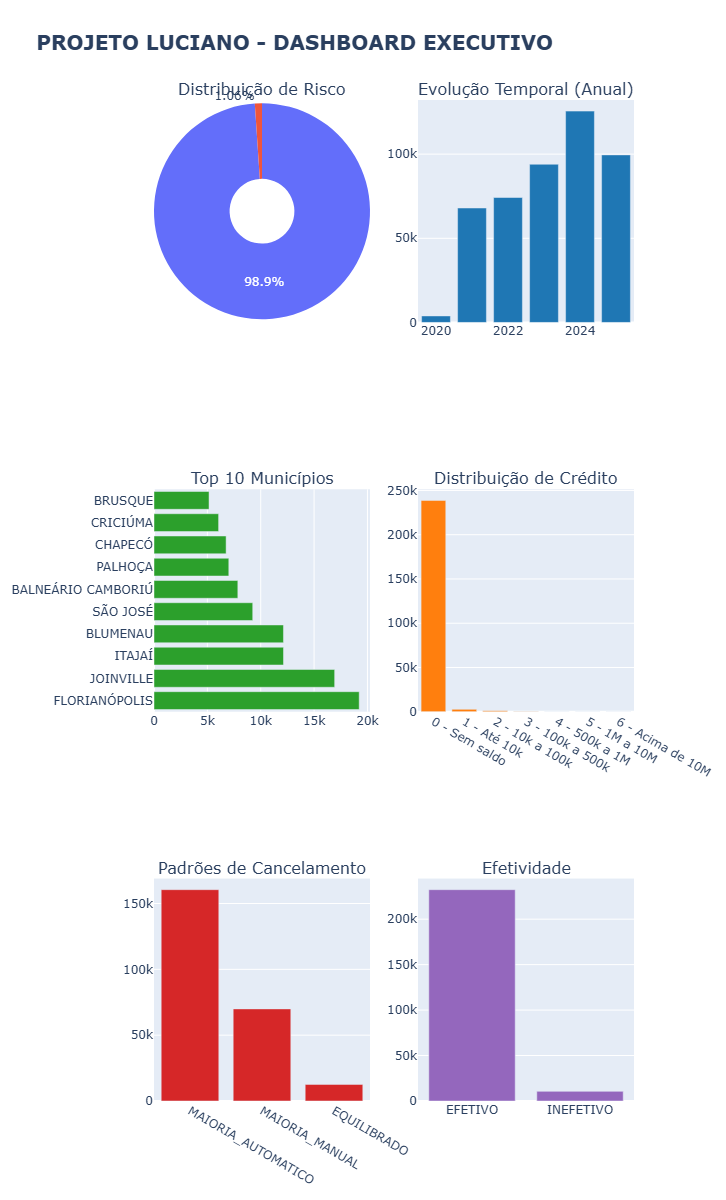


✅ Dashboard salvo: DASHBOARD_EXECUTIVO.html

🎉 VISUALIZAÇÕES CONCLUÍDAS!


In [19]:
# ===================================================================
# CÉLULA 12: RESUMO EXECUTIVO VISUAL (BÔNUS)
# ===================================================================

import plotly.graph_objects as go
from plotly.subplots import make_subplots

print("\n" + "="*80)
print("📊 GERANDO VISUALIZAÇÕES EXECUTIVAS")
print("="*80)

# Criar dashboard visual com principais métricas
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=(
        'Distribuição de Risco',
        'Evolução Temporal (Anual)',
        'Top 10 Municípios',
        'Distribuição de Crédito',
        'Padrões de Cancelamento',
        'Efetividade'
    ),
    specs=[[{'type': 'pie'}, {'type': 'bar'}],
           [{'type': 'bar'}, {'type': 'bar'}],
           [{'type': 'bar'}, {'type': 'bar'}]]
)

# 1. Distribuição de Risco (Pizza)
if len(df_risco) > 0:
    fig.add_trace(
        go.Pie(labels=df_risco['classificacao_risco_final'],
               values=df_risco['qtde_empresas'],
               hole=0.3),
        row=1, col=1
    )

# 2. Evolução Temporal (Barras)
if len(df_temporal_anual) > 0:
    fig.add_trace(
        go.Bar(x=df_temporal_anual['ano_cancelamento'],
               y=df_temporal_anual['total_protocolos'],
               marker_color='#1f77b4'),
        row=1, col=2
    )

# 3. Top 10 Municípios
if len(df_municipio) > 0:
    top10_mun = df_municipio.head(10)
    fig.add_trace(
        go.Bar(y=top10_mun['municipio'],
               x=top10_mun['qtde_empresas'],
               orientation='h',
               marker_color='#2ca02c'),
        row=2, col=1
    )

# 4. Distribuição de Crédito
if len(df_credito) > 0:
    fig.add_trace(
        go.Bar(x=df_credito['faixa_saldo'],
               y=df_credito['qtde_empresas'],
               marker_color='#ff7f0e'),
        row=2, col=2
    )

# 5. Padrões de Cancelamento
if len(df_padroes) > 0:
    fig.add_trace(
        go.Bar(x=df_padroes['padrao_cancelamento_predominante'],
               y=df_padroes['qtde_empresas'],
               marker_color='#d62728'),
        row=3, col=1
    )

# 6. Efetividade
if len(df_efetividade) > 0:
    fig.add_trace(
        go.Bar(x=df_efetividade['efetividade_cancelamento'],
               y=df_efetividade['qtde_empresas'],
               marker_color='#9467bd'),
        row=3, col=2
    )

fig.update_layout(
    height=1200,
    showlegend=False,
    title_text="<b>PROJETO LUCIANO - DASHBOARD EXECUTIVO</b>",
    title_font_size=20
)

fig.show()

# Salvar dashboard como HTML
html_path = "DASHBOARD_EXECUTIVO.html"
fig.write_html(html_path)
print(f"\n✅ Dashboard salvo: {html_path}")

print("\n🎉 VISUALIZAÇÕES CONCLUÍDAS!")